# Model Explainability, A/B testing and Shadow Testing 

Imagine you're a data scientist who has successfully developed a direct marketing AI model using Amazon SageMaker in the main section of this workshop. The model has shown promising results, and the value SageMakers ease of development and deployment has been proven to your manager. 

Based on that success, your manager has now tasked you with improving the model's accuracy and introducing A/B testing before putting it into production. Your call center agents have told you, that it is hard for them to know why the model has predicted the outcome and want to understand the 

As a data scientist, you recognize the importance of model explainability not only for improving model accuracy but also for providing insights that can help call center agents better tailor their message to customers. By providing explainable results, agents can better understand the factors driving a customer's likelihood to convert and adjust their messaging accordingly. 

In this notebook, we will explore how to incorporate explainability into the direct marketing AI model for the call center and provide a step-by-step guide for using A/B testing and shadow testing to evaluate the new model's performance. By doing so, we can ensure that the model is not only accurate but also transparent and understandable, empowering call center agents to effectively engage with customers and drive better outcomes.

## Prerequisites
To run this notebook you must have:
1. Complete the **Hyperparameter optimization** section from the [`02-sagemaker-containers`](../02-sagemaker-containers.ipynb) notebook

Alternatively you can create a new model that you would like to A/B test against the model trained by the [`step 3`](../03-sagemaker-pipeline.ipynb) pipeline.

In [36]:
import time
import os
import json
import boto3
import numpy as np  
import botocore
import pandas as pd 
import sagemaker
from time import gmtime, strftime, sleep
from sklearn.metrics import roc_auc_score
import sagemaker 
from time import gmtime, strftime, sleep
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sklearn.metrics import roc_auc_score
from sagemaker.experiments.run import Run, load_run
from sagemaker import get_execution_role
sagemaker.__version__

'2.135.0'

In [37]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

session = sagemaker.Session()
sm = session.sagemaker_client

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Stored variables and their in-db values:
baseline_s3_url_catboost               -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
bucket_name                            -> 'sagemaker-us-east-1-510646607739'
bucket_prefix                          -> 'from-idea-to-prod/xgboost'
bucket_prefix_catboost                 -> 'from-idea-to-prod/catboost'
domain_id                              -> None
experiment_name                        -> 'Model-Improvement-Efforts-22-17-46-44'
initialized                            -> True
input_s3_url_catboost                  -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
output_s3_url                          -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
region                                 -> 'us-east-1'
sm_role                                -> 'arn:aws:iam::510646607739:role/service-role/Amazo
test_s3_url_catboost                   -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
train_s3_url_catboost                  -> 's3:

UnknownServiceError: Unknown service: 'sagemaker-metrics'. Valid service names are: accessanalyzer, account, acm, acm-pca, alexaforbusiness, amp, amplify, amplifybackend, amplifyuibuilder, apigateway, apigatewaymanagementapi, apigatewayv2, appconfig, appconfigdata, appflow, appintegrations, application-autoscaling, application-insights, applicationcostprofiler, appmesh, apprunner, appstream, appsync, athena, auditmanager, autoscaling, autoscaling-plans, backup, backup-gateway, backupstorage, batch, billingconductor, braket, budgets, ce, chime, chime-sdk-identity, chime-sdk-media-pipelines, chime-sdk-meetings, chime-sdk-messaging, cloud9, cloudcontrol, clouddirectory, cloudformation, cloudfront, cloudhsm, cloudhsmv2, cloudsearch, cloudsearchdomain, cloudtrail, cloudwatch, codeartifact, codebuild, codecommit, codedeploy, codeguru-reviewer, codeguruprofiler, codepipeline, codestar, codestar-connections, codestar-notifications, cognito-identity, cognito-idp, cognito-sync, comprehend, comprehendmedical, compute-optimizer, config, connect, connect-contact-lens, connectcampaigns, connectparticipant, cur, customer-profiles, databrew, dataexchange, datapipeline, datasync, dax, detective, devicefarm, devops-guru, directconnect, discovery, dlm, dms, docdb, drs, ds, dynamodb, dynamodbstreams, ebs, ec2, ec2-instance-connect, ecr, ecr-public, ecs, efs, eks, elastic-inference, elasticache, elasticbeanstalk, elastictranscoder, elb, elbv2, emr, emr-containers, emr-serverless, es, events, evidently, finspace, finspace-data, firehose, fis, fms, forecast, forecastquery, frauddetector, fsx, gamelift, gamesparks, glacier, globalaccelerator, glue, grafana, greengrass, greengrassv2, groundstation, guardduty, health, healthlake, honeycode, iam, identitystore, imagebuilder, importexport, inspector, inspector2, iot, iot-data, iot-jobs-data, iot1click-devices, iot1click-projects, iotanalytics, iotdeviceadvisor, iotevents, iotevents-data, iotfleethub, iotsecuretunneling, iotsitewise, iotthingsgraph, iottwinmaker, iotwireless, ivs, ivschat, kafka, kafkaconnect, kendra, keyspaces, kinesis, kinesis-video-archived-media, kinesis-video-media, kinesis-video-signaling, kinesisanalytics, kinesisanalyticsv2, kinesisvideo, kms, lakeformation, lambda, lex-models, lex-runtime, lexv2-models, lexv2-runtime, license-manager, license-manager-user-subscriptions, lightsail, location, logs, lookoutequipment, lookoutmetrics, lookoutvision, m2, machinelearning, macie, macie2, managedblockchain, marketplace-catalog, marketplace-entitlement, marketplacecommerceanalytics, mediaconnect, mediaconvert, medialive, mediapackage, mediapackage-vod, mediastore, mediastore-data, mediatailor, memorydb, meteringmarketplace, mgh, mgn, migration-hub-refactor-spaces, migrationhub-config, migrationhubstrategy, mobile, mq, mturk, mwaa, neptune, network-firewall, networkmanager, nimble, opensearch, opsworks, opsworkscm, organizations, outposts, panorama, personalize, personalize-events, personalize-runtime, pi, pinpoint, pinpoint-email, pinpoint-sms-voice, pinpoint-sms-voice-v2, polly, pricing, privatenetworks, proton, qldb, qldb-session, quicksight, ram, rbin, rds, rds-data, redshift, redshift-data, redshift-serverless, rekognition, resiliencehub, resource-groups, resourcegroupstaggingapi, robomaker, rolesanywhere, route53, route53-recovery-cluster, route53-recovery-control-config, route53-recovery-readiness, route53domains, route53resolver, rum, s3, s3control, s3outposts, sagemaker, sagemaker-a2i-runtime, sagemaker-edge, sagemaker-featurestore-runtime, sagemaker-runtime, savingsplans, schemas, sdb, secretsmanager, securityhub, serverlessrepo, service-quotas, servicecatalog, servicecatalog-appregistry, servicediscovery, ses, sesv2, shield, signer, sms, sms-voice, snow-device-management, snowball, sns, sqs, ssm, ssm-contacts, ssm-incidents, sso, sso-admin, sso-oidc, stepfunctions, storagegateway, sts, support, support-app, swf, synthetics, textract, timestream-query, timestream-write, transcribe, transfer, translate, voice-id, waf, waf-regional, wafv2, wellarchitected, wisdom, workdocs, worklink, workmail, workmailmessageflow, workspaces, workspaces-web, xray

In [38]:
boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()
bucket_prefix = "from-idea-to-prod/xgboost"
bucket_prefix_catboost = "from-idea-to-prod/catboost"
# Define where the training job stores the model artifact
output_s3_url = f"s3://{bucket_name}/{bucket_prefix_catboost}/output"

%store output_s3_url
sm_session = sagemaker.Session()
sm_client = boto_session.client("sagemaker")
try:
    sm_role = sagemaker.get_execution_role()
except ValueError:
    print("No SageMaker execution role found. Using default role. Looking in a for a config file named 'config.json' in the current directory.")
    import json

    # Load the configuration file
    with open('../config.json', 'r') as f:
        config = json.load(f)

    # Access the execution_role field
    sm_role = config['sagemaker-execution-role']
    

initialized = True

print(sm_role)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


UnknownServiceError: Unknown service: 'sagemaker-metrics'. Valid service names are: accessanalyzer, account, acm, acm-pca, alexaforbusiness, amp, amplify, amplifybackend, amplifyuibuilder, apigateway, apigatewaymanagementapi, apigatewayv2, appconfig, appconfigdata, appflow, appintegrations, application-autoscaling, application-insights, applicationcostprofiler, appmesh, apprunner, appstream, appsync, athena, auditmanager, autoscaling, autoscaling-plans, backup, backup-gateway, backupstorage, batch, billingconductor, braket, budgets, ce, chime, chime-sdk-identity, chime-sdk-media-pipelines, chime-sdk-meetings, chime-sdk-messaging, cloud9, cloudcontrol, clouddirectory, cloudformation, cloudfront, cloudhsm, cloudhsmv2, cloudsearch, cloudsearchdomain, cloudtrail, cloudwatch, codeartifact, codebuild, codecommit, codedeploy, codeguru-reviewer, codeguruprofiler, codepipeline, codestar, codestar-connections, codestar-notifications, cognito-identity, cognito-idp, cognito-sync, comprehend, comprehendmedical, compute-optimizer, config, connect, connect-contact-lens, connectcampaigns, connectparticipant, cur, customer-profiles, databrew, dataexchange, datapipeline, datasync, dax, detective, devicefarm, devops-guru, directconnect, discovery, dlm, dms, docdb, drs, ds, dynamodb, dynamodbstreams, ebs, ec2, ec2-instance-connect, ecr, ecr-public, ecs, efs, eks, elastic-inference, elasticache, elasticbeanstalk, elastictranscoder, elb, elbv2, emr, emr-containers, emr-serverless, es, events, evidently, finspace, finspace-data, firehose, fis, fms, forecast, forecastquery, frauddetector, fsx, gamelift, gamesparks, glacier, globalaccelerator, glue, grafana, greengrass, greengrassv2, groundstation, guardduty, health, healthlake, honeycode, iam, identitystore, imagebuilder, importexport, inspector, inspector2, iot, iot-data, iot-jobs-data, iot1click-devices, iot1click-projects, iotanalytics, iotdeviceadvisor, iotevents, iotevents-data, iotfleethub, iotsecuretunneling, iotsitewise, iotthingsgraph, iottwinmaker, iotwireless, ivs, ivschat, kafka, kafkaconnect, kendra, keyspaces, kinesis, kinesis-video-archived-media, kinesis-video-media, kinesis-video-signaling, kinesisanalytics, kinesisanalyticsv2, kinesisvideo, kms, lakeformation, lambda, lex-models, lex-runtime, lexv2-models, lexv2-runtime, license-manager, license-manager-user-subscriptions, lightsail, location, logs, lookoutequipment, lookoutmetrics, lookoutvision, m2, machinelearning, macie, macie2, managedblockchain, marketplace-catalog, marketplace-entitlement, marketplacecommerceanalytics, mediaconnect, mediaconvert, medialive, mediapackage, mediapackage-vod, mediastore, mediastore-data, mediatailor, memorydb, meteringmarketplace, mgh, mgn, migration-hub-refactor-spaces, migrationhub-config, migrationhubstrategy, mobile, mq, mturk, mwaa, neptune, network-firewall, networkmanager, nimble, opensearch, opsworks, opsworkscm, organizations, outposts, panorama, personalize, personalize-events, personalize-runtime, pi, pinpoint, pinpoint-email, pinpoint-sms-voice, pinpoint-sms-voice-v2, polly, pricing, privatenetworks, proton, qldb, qldb-session, quicksight, ram, rbin, rds, rds-data, redshift, redshift-data, redshift-serverless, rekognition, resiliencehub, resource-groups, resourcegroupstaggingapi, robomaker, rolesanywhere, route53, route53-recovery-cluster, route53-recovery-control-config, route53-recovery-readiness, route53domains, route53resolver, rum, s3, s3control, s3outposts, sagemaker, sagemaker-a2i-runtime, sagemaker-edge, sagemaker-featurestore-runtime, sagemaker-runtime, savingsplans, schemas, sdb, secretsmanager, securityhub, serverlessrepo, service-quotas, servicecatalog, servicecatalog-appregistry, servicediscovery, ses, sesv2, shield, signer, sms, sms-voice, snow-device-management, snowball, sns, sqs, ssm, ssm-contacts, ssm-incidents, sso, sso-admin, sso-oidc, stepfunctions, storagegateway, sts, support, support-app, swf, synthetics, textract, timestream-query, timestream-write, transcribe, transfer, translate, voice-id, waf, waf-regional, wafv2, wellarchitected, wisdom, workdocs, worklink, workmail, workmailmessageflow, workspaces, workspaces-web, xray

In [6]:
# This cell is tagged with `parameters` tag and will be overwritten if the notebook executed headlessly
file_source = "EFS"
file_name = "bank-additional-full.csv"
input_path = "../data/bank-additional" 
output_path = "./data"

df_data = pd.read_csv(os.path.join(input_path, file_name), sep=";")

pd.set_option("display.max_columns", 500)  # View all of the columns
df_data  # show first 5 and last 5 rows of the dataframe

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [7]:
experiment_name = f"Model-Improvement-Efforts-{strftime('%d-%H-%M-%S', gmtime())}"

In [8]:
%store experiment_name

Stored 'experiment_name' (str)


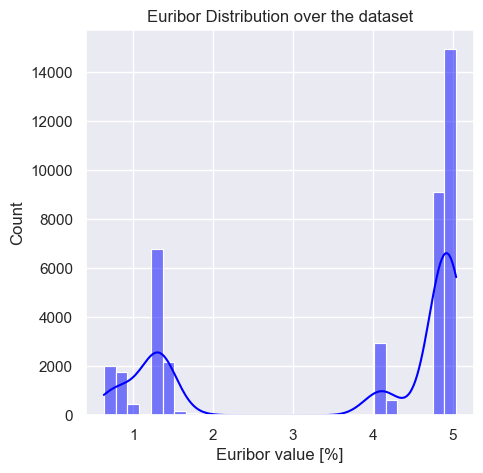

In [9]:
# plot the euribor data 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(5,5)})
sns.histplot(df_data['euribor3m'], bins=30, kde=True, color='blue')
# set the title, x and y labels
plt.title('Euribor Distribution over the dataset')
plt.xlabel('Euribor value [%]')
plt.ylabel('Count')
plt.show()

As can be seen, the Euribor (the interest rate set by the European central bank for lending money to the banks) has strong fluctution in the recorded time. Therefore, we will leave it as a macro-economic feature. 

Furthermore, we will try to use a meaningful mapping wherever possible instead of just one-hot-encoding everything. As we already know how to use Processing Jobs, we will utilize it here directly.

In [10]:
train_s3_url_catboost = f"s3://{bucket_name}/{bucket_prefix_catboost}/train"
validation_s3_url_catboost = f"s3://{bucket_name}/{bucket_prefix_catboost}/validation"
test_s3_url_catboost = f"s3://{bucket_name}/{bucket_prefix_catboost}/test"
baseline_s3_url_catboost = f"s3://{bucket_name}/{bucket_prefix_catboost}/baseline"

In [11]:
%store train_s3_url_catboost
%store validation_s3_url_catboost
%store test_s3_url_catboost
%store baseline_s3_url_catboost

Stored 'train_s3_url_catboost' (str)
Stored 'validation_s3_url_catboost' (str)
Stored 'test_s3_url_catboost' (str)
Stored 'baseline_s3_url_catboost' (str)


In [24]:
%%writefile preprocessing_catboost.py

import pandas as pd
import numpy as np
import argparse
import os

def _parse_args():
    
    parser = argparse.ArgumentParser()
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    
    return parser.parse_known_args()


if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    
    target_col = "y"
    
    # Load data
    df_data = pd.read_csv(os.path.join(args.filepath, args.filename), sep=";")

    # starting with the variables that have order and we want to map
    targetMapping = {'no':0, 'yes':1}
    educationMapping = {'illiterate':0, 'basic.4y':1, 'basic.6y':1, 'basic.9y':2,
                        'high.school':3,'professional.course':4, 'university.degree':5,
                        'unknown':-999}
    dayMapping = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
    monthMapping = {'jan': 1, 'feb': 2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
    defaultMapping = {"no":0,"yes":1,"unknown":-999}
    housingMapping = {"no":0,"yes":1,"unknown":-999}
    loanMapping = {"no":0,"yes":1,"unknown":-999}
    poutcomeMapping = {"failure":0,"nonexistent":-999,"success":1}
    contactMapping = {'telephone':0, 'cellular':1}

    df = df_data.copy()
    df['y'] = df['y'].map(targetMapping)
    df['education'] = df['education'].map(educationMapping)
    df['day_of_week'] = df['day_of_week'].map(dayMapping)
    df['month'] = df['month'].map(monthMapping)
    df['default'] = df['default'].map(defaultMapping)
    df['housing'] = df['housing'].map(housingMapping)
    df['loan'] = df['loan'].map(loanMapping)
    df['poutcome'] = df['poutcome'].map(poutcomeMapping)
    df['contact'] = df['contact'].map(contactMapping)
    df.drop('duration', axis = 1, inplace = True)
    
    # reordering the columns 
    cols = df.columns.tolist()
    cols = [target_col] + [col for col in cols if col not in [target_col] ]
    df = df[cols] 
    # Shuffle and splitting dataset
    train_data, validation_data, test_data = np.split(
        df.sample(frac=1, random_state=1729),
        [int(0.7 * len(df)), int(0.9 * len(df))],
    )
    
    print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
    
    # Save datasets locally
    train_data.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
    validation_data.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
    test_data[target_col].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
    test_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
    
    # Save the baseline dataset for model monitoring
    df.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'baseline/baseline.csv'), index=False, header=False)
    
    print("## Processing complete. Exiting.")

Overwriting preprocessing_catboost.py


In [25]:
input_s3_url_catboost = session.upload_data(
    path="../data/bank-additional/bank-additional-full.csv",
    bucket=bucket_name,
    key_prefix=f"{bucket_prefix_catboost}/input"
)

%store input_s3_url_catboost

framework_version = "0.23-1"
processing_instance_type = "ml.m5.large"
processing_instance_count = 1

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    role=sm_role,
    instance_type=processing_instance_type,
    # instance_type="local",
    instance_count=processing_instance_count, 
    base_job_name='from-idea-to-prod-processing',
    sagemaker_session=session,
)

processing_inputs = [
        ProcessingInput(
            source=input_s3_url_catboost, 
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            # s3_data_distribution_type="ShardedByS3Key"
        )
    ]

processing_outputs = [
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_s3_url_catboost,
        ),
        ProcessingOutput(
            output_name="validation_data", 
            source="/opt/ml/processing/output/validation", 
            destination=validation_s3_url_catboost
        ),
        ProcessingOutput(
            output_name="test_data", 
            source="/opt/ml/processing/output/test", 
            destination=test_s3_url_catboost
        ),
        ProcessingOutput(
            output_name="baseline_data", 
            source="/opt/ml/processing/output/baseline", 
            destination=baseline_s3_url_catboost
        ),
    ]

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Stored 'input_s3_url_catboost' (str)


In [26]:
try:
    sklearn_processor.run(
        inputs=processing_inputs,
        outputs=processing_outputs,
        code='preprocessing_catboost.py',
        wait=True)
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
    else:
        raise e

INFO:sagemaker:Creating processing-job with name from-idea-to-prod-processing-2023-03-23-07-49-05-549


..........................Data split > train:(28831, 20) | validation:(8238, 20) | test:(4119, 20)
## Processing complete. Exiting.



Lets create a HPO job to get the best possilbe model of catboost


In [33]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "catboost-classification-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)

train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

# s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"


from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"built-in-algo-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=output_s3_url
)

# # Launch a SageMaker Training job by passing the S3 path of the training data
# tabular_estimator.fit(
#     {
#         "training": training_dataset_s3_path,
#         "validation": validation_dataset_s3_path,
#     }, logs=True, job_name=training_job_name
# )

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


NameError: name 'aws_role' is not defined

In [26]:
# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

In [27]:
# set up hyperparameter ranges
hp_ranges = {
    "min_child_weight": ContinuousParameter(1, 10),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
    "colsample_bytree": ContinuousParameter(0, 1),
    "gamma": ContinuousParameter(0, 10)
    
}

# set up the objective metric
objective = "validation:auc"

# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator=estimator,  # the SageMaker estimator object
    hyperparameter_ranges=hp_ranges,  # the range of hyperparameters
    max_jobs=30,  # total number of HPO jobs
    max_parallel_jobs=3,  # how many HPO jobs can run in parallel
    strategy="Bayesian",  # the internal optimization strategy of HPO
    objective_metric_name=objective,  # the objective metric to be used for HPO
    objective_type="Maximize",  # maximize or minimize the objective metric
    base_tuning_job_name="from-idea-to-prod-hpo",
    early_stopping_type="Auto",
)

NameError: name 'estimator' is not defined

Stored variables and their in-db values:
bucket_name                        -> 'sagemaker-us-east-1-510646607739'
bucket_prefix                      -> 'from-idea-to-prod/xgboost'
bucket_prefix_catboost             -> 'from-idea-to-prod/catboost'
domain_id                          -> None
experiment_name                    -> 'Model-Improvement-Efforts-22-14-49-51'
initialized                        -> True
region                             -> 'us-east-1'
sm_role                            -> 'arn:aws:iam::510646607739:role/service-role/Amazo


In [ ]:
print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
    
# Save datasets locally
train_data.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
validation_data.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
test_data[target_col].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
test_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)

# Save the baseline dataset for model monitoring
df_model_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'baseline/baseline.csv'), index=False, header=False)

print("## Processing complete. Exiting.")

<AxesSubplot: title={'center': 'Duration of calls histogram [sec]'}, ylabel='Frequency'>

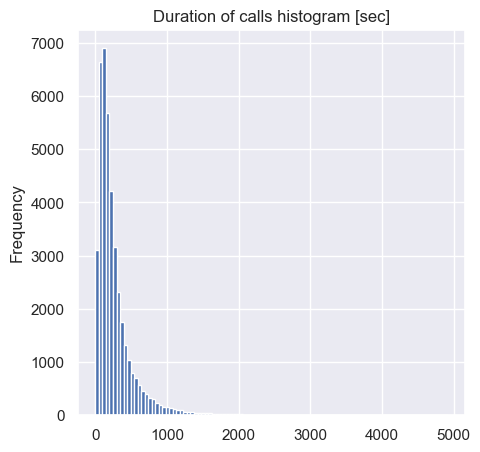

In [41]:
# plot the duration data and color it by the target variable
df.duration.plot(kind='hist', bins=100, title='Duration of calls histogram [sec]')

In [54]:
# how long does a call usually take if the call was not successful? 
(df.loc[(df["duration"]>0) & (df["y"]==1)].duration/60).describe()

count    4640.000000
mean        9.219853
std         6.686198
min         0.616667
25%         4.216667
50%         7.483333
75%        12.354167
max        69.983333
Name: duration, dtype: float64

In [55]:
# how long does a call usually take if the call was not successful? 
(df.loc[(df["duration"]>0) & (df["y"]==0)].duration/60).describe()

count    36544.000000
mean         3.681150
std          3.451579
min          0.016667
25%          1.583333
50%          2.733333
75%          4.650000
max         81.966667
Name: duration, dtype: float64

## Further development ideas for your real-world projects

## Additional resources
- [Safely validate models in production](https://docs.aws.amazon.com/sagemaker/latest/dg/model-validation.html)
- [A/B Testing with Amazon SageMaker](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_endpoints/a_b_testing/a_b_testing.html)
- [A/B Testing ML models in production using Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/a-b-testing-ml-models-in-production-using-amazon-sagemaker/)

# Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>